In [1]:
import pandas as pd

In [3]:
titanic_csv = pd.read_csv('files/train.csv')
titanic_csv.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [190]:
titanic_csv.shape

(891, 12)

In [191]:
column: str = titanic_csv.columns[0] # Retorna cabecera de la columna
titanic_csv[column]

0        1
1        2
2        3
3        4
4        5
      ... 
886    887
887    888
888    889
889    890
890    891
Name: PassengerId, Length: 891, dtype: int64

# Columns to omit:
- Name : Column 4
- PassengerId : column 1
- Fare : column 10
- Embarked : column 12
- Ticket : column 9

In [192]:
# Traspaso a un nuevo pandas.Dataframe omitiendo las columnas indicadas
titanic_df = titanic_csv.drop(columns=['Name', 'PassengerId', 'Fare', 'Embarked', 'Ticket'])

In [193]:
column_name = titanic_df.columns[6]
titanic_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Cabin
0,0,3,male,22.0,1,0,NaN
1,1,1,female,38.0,1,0,C85
2,1,3,female,26.0,0,0,NaN
3,1,1,female,35.0,1,0,C123
4,0,3,male,35.0,0,0,NaN


In [194]:
# Dataframe.nunique(dropna=False) retorna conteo valores unicos incluyendo valores nan

# Columna Survived no tiene valores nan
titanic_df['Survived'] = titanic_df['Survived'].astype(float)

# Columna Pclass no tiene valores nan
titanic_df['Pclass'] = titanic_df['Pclass'].astype(float)

# Columna Sex no tiene valores nan
# Se pasan los valores male and female a numericos
titanic_df['Sex'] = titanic_df['Sex'].apply(lambda value: 1 if value == 'male' else 0)
titanic_df['Sex'] = titanic_df['Sex'].astype(float)

# Columna Age tiene valores nan
# Se rellena con valores 0 los nan
titanic_df['Age'] = titanic_df['Age'].fillna(0)
titanic_df['Age'] = titanic_df['Age'].astype(float)

# Columna SibSp no tiene valores nan
titanic_df['SibSp'] = titanic_df['SibSp'].astype(float)

# Columna Parch no tiene valores nan
titanic_df['Parch'] = titanic_df['Parch'].astype(float)

# Cabin tiene valores nan y se reemplazan por valores 0
titanic_df['Cabin'], unique = titanic_df['Cabin'].factorize(use_na_sentinel=True)
titanic_df['Cabin'] = titanic_df['Cabin'].replace(-1, 150)
titanic_df['Cabin'] = titanic_df['Cabin'].astype(float)

In [195]:
titanic_df['Cabin'].unique()

array([150.,   0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,
        10.,  11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,
        21.,  22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,
        32.,  33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,
        43.,  44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,
        54.,  55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,
        65.,  66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,
        76.,  77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,
        87.,  88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,
        98.,  99., 100., 101., 102., 103., 104., 105., 106., 107., 108.,
       109., 110., 111., 112., 113., 114., 115., 116., 117., 118., 119.,
       120., 121., 122., 123., 124., 125., 126., 127., 128., 129., 130.,
       131., 132., 133., 134., 135., 136., 137., 138., 139., 140., 141.,
       142., 143., 144., 145., 146.])

In [196]:
from sklearn.model_selection import train_test_split

# Separa valores en test y train
x_df = titanic_df.drop(columns=['Survived'])
y_df = titanic_df['Survived']

X_train, X_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.2, random_state=42)


In [197]:
# Escalar valores entre
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [198]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# Creación de tensors

X_train_tensor = torch.tensor(data=X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(data=X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

train_dataset_tensor = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset_tensor = TensorDataset(X_test_tensor, y_test_tensor)

# Creacion de DataLoader
batch_size = 32
train_loader = DataLoader(dataset=train_dataset_tensor, batch_size=batch_size)
test_loader = DataLoader(dataset=test_dataset_tensor, batch_size=batch_size)

In [267]:
import torch.nn as nn

# Creación del modelo
class TitanicModel(nn.Module):
    def __init__(self, input_size):
        super(TitanicModel, self).__init__()
        self.fc1 = nn.Linear(in_features=input_size, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=64)
        self.fc3 = nn.Linear(in_features=64, out_features=1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu( self.fc2(x))
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x




In [268]:
from torch import optim

input_size: int = X_train_tensor.shape[1]
titanic_model = TitanicModel(input_size=input_size)
criterion = nn.BCELoss()
optimizer = optim.Adam(titanic_model.parameters(), lr=0.001)


In [269]:
def train(model, train_loader, optimizer, criterion, epochs):

    loss_list_train = []
    iteration_list_train = []

    for epoch in range(epochs):
        model.train()
        epoch_loss_train = 0.0

        for index, (batch_x, batch_y) in enumerate(train_loader):
            optimizer.zero_grad()

            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)

            loss.backward()
            optimizer.step()

            epoch_loss_train += loss.item()

        loss_mean = epoch_loss_train / len(train_loader)
        loss_list_train.append(loss_mean)
        iteration_list_train.append(epoch + 1)

    return loss_list_train, iteration_list_train


In [270]:
def test(model, test_loader, criterion):
    model.eval()
    epoch_loss_test = 0.0
    loss_list_test = []
    iteration_list_test = []

    with torch.no_grad():
        for index, (batch_x, batch_y) in enumerate(test_loader):
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            epoch_loss_test += loss.item()

            print(f'Epoch {index + 1}/{len(test_loader)} Loss: {loss.item():.4f}')

            loss_list_test.append(loss.item())
            iteration_list_test.append(index + 1)


    loss_test_mean = epoch_loss_test / len(test_loader)
    return iteration_list_test, loss_list_test, loss_test_mean

In [271]:
epochs: int = 1000
loss_list_train, iteration_list_train = train(model=titanic_model, train_loader=train_loader, optimizer=optimizer, criterion=criterion, epochs=epochs)

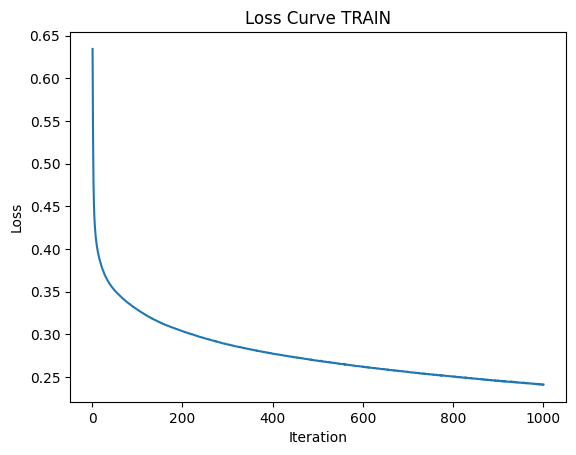

In [272]:
import matplotlib.pyplot as plt

plt.plot(iteration_list_train, loss_list_train)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss Curve TRAIN')
plt.show()

In [273]:
iteration_list_test, loss_list_test, loss_test_mean = test(model=titanic_model, test_loader=test_loader, criterion=criterion)

Epoch 1/6 Loss: 0.8799
Epoch 2/6 Loss: 0.6229
Epoch 3/6 Loss: 7.1818
Epoch 4/6 Loss: 0.8334
Epoch 5/6 Loss: 0.8800
Epoch 6/6 Loss: 1.4408


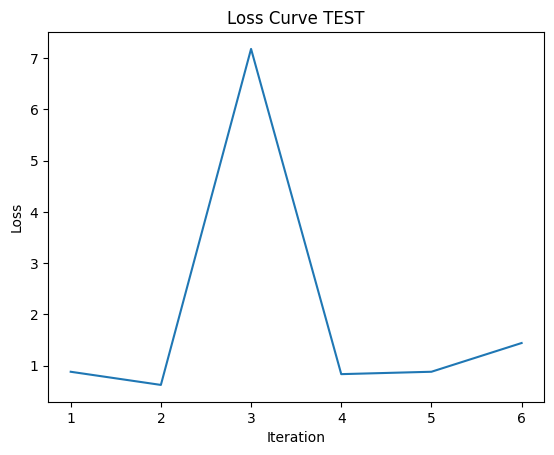

In [274]:
plt.plot(iteration_list_test, loss_list_test)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss Curve TEST')
plt.show()

In [229]:
# Testing for kaggle competition
test_csv = pd.read_csv('files/test.csv')
test_csv.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [230]:
test_df = test_csv.drop(columns=['Name', 'PassengerId', 'Fare', 'Embarked', 'Ticket'])

test_df['Pclass'] = test_df['Pclass'].astype(float)

test_df['Sex'] = test_df['Sex'].apply(lambda value: 1 if value == 'male' else 0)
test_df['Sex'] = test_df['Sex'].astype(float)

test_df['Age'] = test_df['Age'].fillna(0)
test_df['Age'] = test_df['Age'].astype(float)

test_df['SibSp'] = test_df['SibSp'].astype(float)

test_df['Parch'] = test_df['Parch'].astype(float)

test_df['Cabin'], unique = test_df['Cabin'].factorize(use_na_sentinel=True)
test_df['Cabin'] = test_df['Cabin'].replace(-1, 150)
test_df['Cabin'] = test_df['Cabin'].astype(float)

In [ ]:
# Columna Survived no tiene valores nan


# Columna Pclass no tiene valores nan


# Columna Sex no tiene valores nan
# Se pasan los valores male and female a numericos


# Columna Age tiene valores nan
# Se rellena con valores 0 los nan


# Columna SibSp no tiene valores nan


# Columna Parch no tiene valores nan


# Cabin tiene valores nan y se reemplazan por valores 0


In [231]:
test_df

,Pclass,Sex,Age,SibSp,Parch,Cabin
0,3.0,1.0,34.5,0.0,0.0,150.0
1,3.0,0.0,47.0,1.0,0.0,150.0
2,2.0,1.0,62.0,0.0,0.0,150.0
3,3.0,1.0,27.0,0.0,0.0,150.0
4,3.0,0.0,22.0,1.0,1.0,150.0
...,...,...,...,...,...,...
413,3.0,1.0,0.0,0.0,0.0,150.0
414,1.0,0.0,39.0,0.0,0.0,75.0
415,3.0,1.0,38.5,0.0,0.0,150.0
416,3.0,1.0,0.0,0.0,0.0,150.0


In [232]:
test_df = sc.transform(test_df)

In [233]:
test_df

array([[ 0.81303367,  0.7243102 ,  0.61740528, -0.47072241, -0.47934164,
         0.46507269],
       [ 0.81303367, -1.38062393,  1.33189623,  0.37992316, -0.47934164,
         0.46507269],
       [-0.40055118,  0.7243102 ,  2.18928537, -0.47072241, -0.47934164,
         0.46507269],
       ...,
       [ 0.81303367,  0.7243102 ,  0.84604238, -0.47072241, -0.47934164,
         0.46507269],
       [ 0.81303367,  0.7243102 , -1.35458975, -0.47072241, -0.47934164,
         0.46507269],
       [ 0.81303367,  0.7243102 , -1.35458975,  0.37992316,  0.78470001,
         0.46507269]])

In [241]:
test_df_tensor = torch.tensor(data=test_df, dtype=torch.float32)

In [275]:
titanic_model.eval()
with torch.no_grad():
    predictions = titanic_model(test_df_tensor)

In [276]:
predictions = (predictions > 0.5).int()
predictions

tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [0],
        [1],
        [0],
        [0],
        [1],
        [1],
        [0],
        [1],
        [1],
        [0],
        [0],
        [0],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [0],
        [1],
        [1],
        [0],
        [0],
        [1],
        [0],
        [0],
        [0],
        [1],
        [1],
        [0],
        [0],
        [0],
        [1],
        [0],
        [1],
        [1],
        [0],
        [0],
        [0],
        [1],
        [1],
        [0],
        [0],
        [1],
        [1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [0],
        [0],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [0],

In [277]:
result = pd.DataFrame({
    'PassengerId': test_csv['PassengerId'],
    'Survived': predictions.numpy().flatten()
})

In [278]:
result.to_csv('files/titanic_predictions.csv', index=False)

In [279]:
result

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
